# Extended Tofts model

In [1]:
# import statements
import itertools
import os
import numpy as np
from matplotlib import pyplot as plt
import csv
import pandas as pd
import seaborn as sns
from plotting_results_nb import plot_bland_altman, bland_altman_statistics
import json
from pathlib import Path

## Background
[to do add some relevant background on the etofts model here]

## Test data

Digital reference object of the brain from Bosca et al. 2016.

Test case labels: test_vox_T{tumour voxel number}_{SNR},e.g. test_vox_T1_30
Selected voxels:
- datVIF=alldata[108,121,6,:]
- datT1=alldata[121,87,6,:] --> tumour voxel 1
- datT2=alldata[156,105,6,:] --> tumour voxel 2
- datT3=alldata[139,93,6,:] --> tumour voxel 3

SNR was added to obtain data at different SNR (20, 30, 50 and 100).
A delayed version of the test data was created by shifting the time curves with 5 time points. This data is labeled as 'delayed' and only used with the models that allow the fitting of a delay.

The DRO data are signal values, which were converted to concentration curves using dce_to_r1eff from https://github.com/welcheb/pydcemri/blob/master from David S. Smith

Input and reference values were found from the accompanying pdf document, which describes the values per voxel.
- T1 blood of 1440 ms
- T1 tissue of 1084 for white matter and 1820 for  grey matter, 1000 for T1-T3
- TR=5 ms
- FA=30
- Hct=0.45

Tolerances
- $v_e$: a_tol=0.05, r_tol=0, start=0.2, bounds=(0,1)
- $v_p$: a_tol=0.025, r_tol=0, start=0.01, bounds=(0,1)
- $K^{trans}$: a_tol=0.005, r_tol=0.1, start=0.6, bounds=(0,5), units [/min]
- delay: a_tol=0.5, r_tol=0, start=0, bounds=(-10,10), units [s]

Source: Bosca, Ryan J., and Edward F. Jackson. "Creating an anthropomorphic digital MR phantom—an extensible tool for comparing and evaluating quantitative imaging algorithms." Physics in Medicine & Biology 61.2 (2016): 974.

### Visualize test data
To get an impression of the test data that was used for the extended Tofts model, below we show the concentration time curves that were the input for the models.
Here we show the data from high SNR from the original (first row) DRO and lowest SNR (SNR = 20; second row).

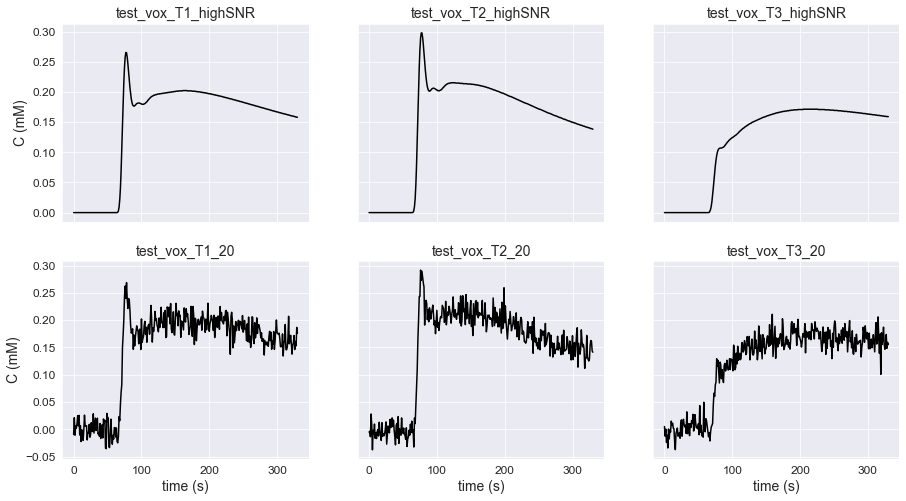

In [2]:
#plot test data
filename = ('../test/DCEmodels/data/dce_DRO_data_extended_tofts.csv')
# read from CSV to pandas
df1 = pd.read_csv(filename)

fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15,8))
for currentvoxel in range(3):
    labelname = 'test_vox_T' + str(currentvoxel+1) + '_highSNR'
    testdata = df1[(df1['label']==labelname)]
    t = testdata['t'].to_numpy()
    t = np.fromstring(t[0], dtype=float, sep=' ')
    c = testdata['C'].to_numpy()
    c = np.fromstring(c[0], dtype=float, sep=' ')
    ax[0,currentvoxel].plot(t, c, color='black', label='highSNR')
    ax[0,currentvoxel].set_title(labelname, fontsize=14)
    if currentvoxel ==0:
        ax[0,currentvoxel].set_ylabel('C (mM)', fontsize=14)
    ax[0,currentvoxel].tick_params(axis='x', labelsize=12)
    ax[0,currentvoxel].tick_params(axis='y', labelsize=12)

    labelname = 'test_vox_T' + str(currentvoxel+1) + '_20'
    testdata = df1[(df1['label']==labelname)]
    t = testdata['t'].to_numpy()
    t = np.fromstring(t[0], dtype=float, sep=' ')
    c = testdata['C'].to_numpy()
    c = np.fromstring(c[0], dtype=float, sep=' ')
    ax[1,currentvoxel].set_title(labelname, fontsize=14)
    ax[1,currentvoxel].plot(t, c, color='black', label='SNR 20')
    ax[1,currentvoxel].set_xlabel('time (s)', fontsize=14)
    if currentvoxel ==0:
        ax[1,currentvoxel].set_ylabel('C (mM)', fontsize=14)
    ax[1,currentvoxel].tick_params(axis='x', labelsize=12)
    ax[1,currentvoxel].tick_params(axis='y', labelsize=12)




## Import data

Import the csv files with test results. The source data are labelled and the difference between measured and reference values was calculated.

In [3]:
# Load the meta data
meta = json.load(open("../test/results/results-meta.json"))

In [4]:
# Loop over each entry and collect the dataframe
df = []
for entry in meta:
    if (entry['category'] == 'DCEmodels') & (entry['method'] == 'etofts') :
        fpath, fname, category, method, author = entry.values()
        df_entry = pd.read_csv(Path(fpath, fname)).assign(author=author)
        df.append(df_entry)

# Concat all entries
df = pd.concat(df)

In [5]:
# split delayed and non-delayed data
df['delay'] = df['label'].str.contains('_delayed')

# label data source
df['source']=''
df.loc[df['label'].str.contains('highSNR'),'source']='highSNR'
df.loc[df['label'].str.contains('_20'),'source']='SNR20'
df.loc[df['label'].str.contains('_30'),'source']='SNR30'
df.loc[df['label'].str.contains('_50'),'source']='SNR50'
df.loc[df['label'].str.contains('_100'),'source']='SNR100'

author_list = df.author.unique()
no_authors = len(author_list)

# calculate error between measured and reference values
df['error_Ktrans'] = df['Ktrans_meas'] - df['Ktrans_ref']
df['error_ve'] = df['ve_meas']- df['ve_ref']
df['error_vp'] = df['vp_meas']- df['vp_ref']

# tolerances
tolerances = { 'Ktrans': {'atol' : 0.005, 'rtol': 0.1 },'ve': {'atol':0.05, 'rtol':0}, 'vp': {'atol':0.025, 'rtol':0}}

## Results

### Non-delayed data

Some models allow the fit of a delay. For the tests with non-delayed data, the delay was fixed to 0.
The data of all test voxels are combined (low and high SNR).

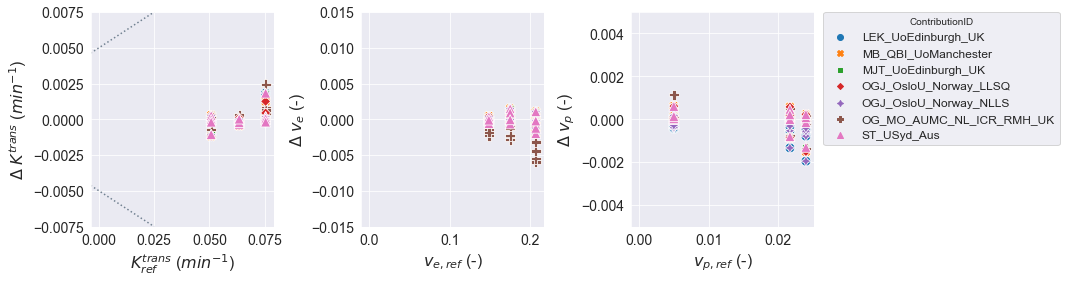

In [6]:
fig, ax = plt.subplots(1,3, sharey='none', figsize=(12,4))
plot_bland_altman(ax[0], df[~df['delay']], tolerances, 'Ktrans', ylim=(-0.0075,0.0075),label_xaxis='$K^{trans}_{ref}$ ($min^{-1}$)',label_yaxis='$\Delta$ $K^{trans}$ ($min^{-1}$)')

plot_bland_altman(ax[1], df[~df['delay']], tolerances, 've', ylim=(-0.015,0.015),label_xaxis='$v_{e,ref}$ (-)',label_yaxis='$\Delta$ $v_{e}$ (-)')
plot_bland_altman(ax[2], df[~df['delay']], tolerances, 'vp', ylim=(-0.005,0.005),label_xaxis='$v_{p,ref}$ (-)',label_yaxis='$\Delta$ $v_{p}$ (-)')
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

# Hide the legend for the left subplot
ax[0].get_legend().set_visible(False)
ax[1].get_legend().set_visible(False)
# Set the position of the legend
plt.legend(bbox_to_anchor=(1.05, 1), title='ContributionID', loc='upper left', borderaxespad=0, fontsize=12);


Bias results estimated $K^{trans}$ values combined for all voxels (low and high SNR)

In [7]:
resultsBA = bland_altman_statistics(data=df[~df['delay']],par='error_Ktrans',grouptag='author')
print(resultsBA)

                              bias     stdev  LoA lower  LoA upper
author                                                            
LEK_UoEdinburgh_UK        0.000003  0.000588  -0.001149   0.001154
MB_QBI_UoManchester      -0.000026  0.000503  -0.001012   0.000960
MJT_UoEdinburgh_UK       -0.000002  0.000587  -0.001152   0.001148
OGJ_OsloU_Norway_LLSQ    -0.000026  0.000503  -0.001012   0.000960
OGJ_OsloU_Norway_NLLS     0.000003  0.000588  -0.001149   0.001154
OG_MO_AUMC_NL_ICR_RMH_UK  0.000380  0.000675  -0.000942   0.001702
ST_USyd_Aus               0.000004  0.000588  -0.001149   0.001156


Bias results estimated $v_e$ values combined for all voxels (low and high SNR)

In [8]:
resultsBA = bland_altman_statistics(data=df[~df['delay']],par='error_ve',grouptag='author')
print(resultsBA)

                              bias     stdev  LoA lower  LoA upper
author                                                            
LEK_UoEdinburgh_UK       -0.000111  0.000865  -0.001807   0.001585
MB_QBI_UoManchester      -0.000113  0.000869  -0.001815   0.001589
MJT_UoEdinburgh_UK       -0.000105  0.000865  -0.001800   0.001590
OGJ_OsloU_Norway_LLSQ    -0.000113  0.000869  -0.001815   0.001589
OGJ_OsloU_Norway_NLLS    -0.000111  0.000865  -0.001807   0.001585
OG_MO_AUMC_NL_ICR_RMH_UK -0.002839  0.001547  -0.005871   0.000192
ST_USyd_Aus              -0.000116  0.000865  -0.001812   0.001579


Bias results estimated $v_p$ values combined for all voxels (low and high SNR)

In [9]:
resultsBA = bland_altman_statistics(data=df[~df['delay']],par='error_vp',grouptag='author')
print(resultsBA)

                              bias     stdev  LoA lower  LoA upper
author                                                            
LEK_UoEdinburgh_UK       -0.000561  0.000508  -0.001556   0.000434
MB_QBI_UoManchester      -0.000041  0.000520  -0.001061   0.000979
MJT_UoEdinburgh_UK       -0.000031  0.000468  -0.000947   0.000885
OGJ_OsloU_Norway_LLSQ    -0.000041  0.000520  -0.001061   0.000979
OGJ_OsloU_Norway_NLLS    -0.000561  0.000508  -0.001556   0.000434
OG_MO_AUMC_NL_ICR_RMH_UK -0.000003  0.000541  -0.001063   0.001056
ST_USyd_Aus              -0.000032  0.000468  -0.000949   0.000884


### Delayed results

Some contributions allowed the fitting of a delay. For those, additional tests with a delay were performed.

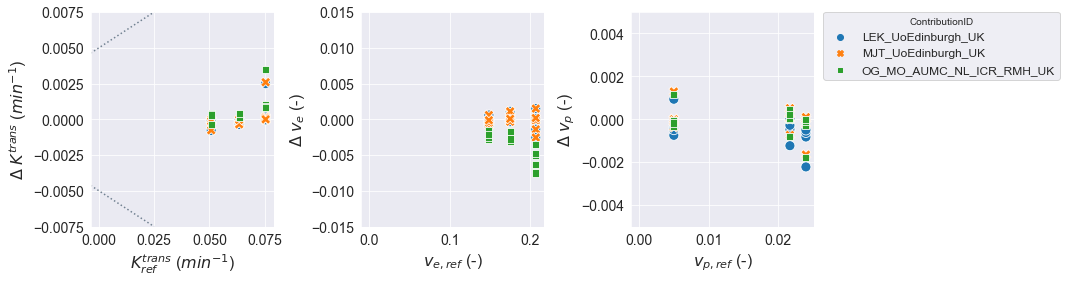

In [10]:
fig, ax = plt.subplots(1,3, sharey='none', figsize=(12,4))
plot_bland_altman(ax[0], df[df['delay']], tolerances, 'Ktrans', ylim=(-0.0075,0.0075),label_xaxis='$K^{trans}_{ref}$ ($min^{-1}$)',label_yaxis='$\Delta$ $K^{trans}$ ($min^{-1}$)')

plot_bland_altman(ax[1], df[df['delay']], tolerances, 've', ylim=(-0.015,0.015),label_xaxis='$v_{e,ref}$ (-)',label_yaxis='$\Delta$ $v_{e}$ (-)')
plot_bland_altman(ax[2], df[df['delay']], tolerances, 'vp', ylim=(-0.005,0.005),label_xaxis='$v_{p,ref}$ (-)',label_yaxis='$\Delta$ $v_{p}$ (-)')
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

# Hide the legend for the left subplot
ax[0].get_legend().set_visible(False)
ax[1].get_legend().set_visible(False)
# Set the position of the legend
plt.legend(bbox_to_anchor=(1.05, 1), title='ContributionID', loc='upper left', borderaxespad=0, fontsize=12);


Bias results estimated $K^{trans}$ values combined for all voxels (low and high SNR)

In [11]:
resultsBA = bland_altman_statistics(data=df[df['delay']],par='error_Ktrans',grouptag='author')
print(resultsBA)

                              bias     stdev  LoA lower  LoA upper
author                                                            
LEK_UoEdinburgh_UK        0.000026  0.000719  -0.001382   0.001435
MJT_UoEdinburgh_UK        0.000044  0.000738  -0.001402   0.001491
OG_MO_AUMC_NL_ICR_RMH_UK  0.000626  0.000876  -0.001091   0.002344


Bias results estimated $v_e$ values combined for all voxels (low and high SNR)

In [12]:
resultsBA = bland_altman_statistics(data=df[df['delay']],par='error_ve',grouptag='author')
print(resultsBA)

                              bias     stdev  LoA lower  LoA upper
author                                                            
LEK_UoEdinburgh_UK       -0.000119  0.001005  -0.002088   0.001850
MJT_UoEdinburgh_UK       -0.000116  0.001003  -0.002082   0.001850
OG_MO_AUMC_NL_ICR_RMH_UK -0.003392  0.001752  -0.006826   0.000042


Bias results estimated $v_p$ values combined for all voxels (low and high SNR)

In [13]:
resultsBA = bland_altman_statistics(data=df[df['delay']],par='error_vp',grouptag='author')
print(resultsBA)

                              bias     stdev  LoA lower  LoA upper
author                                                            
LEK_UoEdinburgh_UK       -0.000556  0.000657  -0.001844   0.000731
MJT_UoEdinburgh_UK       -0.000052  0.000621  -0.001269   0.001165
OG_MO_AUMC_NL_ICR_RMH_UK -0.000122  0.000624  -0.001344   0.001101


### Non-delayed data - ALTERNATIVE FORMAT

Some models allow the fit of a delay. For the tests with non-delayed data, the delay was fixed to 0.
The data of all test voxels are combined (low and high SNR).

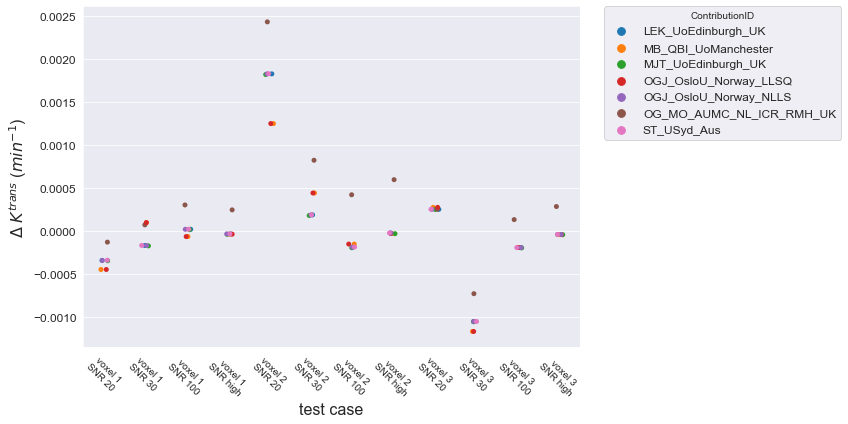

In [14]:
df_new=df[~df['delay']].copy()  # make a copy of the data

# split the label to extract voxel and SNR
df_new[['temp1', 'temp2', 'voxel', 'snr']] = df_new.label.str.split("_", n=3,
                                                              expand = True)
df_new['snr']=df_new['snr'].str.replace('_delayed','')  # remove 'delayed'
df_new['snr']=df_new['snr'].str.replace('highSNR','high')
df_new.drop(['temp1', 'temp2'], axis=1, inplace=True)
df_new['voxel']=df_new['voxel'].str.replace('T','')

# create labels for x axis
df_new['xlabel']='voxel ' + df_new['voxel'] + '\nSNR ' + df_new['snr']

# specify order for these labels
cat_order = [x + '\n' + y for x, y in itertools.product(['voxel 1','voxel 2', 'voxel 3'],
                                           ['SNR 20', 'SNR 30', 'SNR 100',
                                            'SNR high'])]

# make the plot (too many colours - not sure how to change marker symbol)
fig = plt.figure(figsize=(12,6))
ax = sns.stripplot(x='xlabel', y='error_Ktrans', hue='author',
                data=df_new,
            hue_order=df_new.author.sort_values().unique(),
                   order=cat_order,
                   size=5)
ax.set_xlabel('test case', fontsize=16)
ax.set_ylabel('$\Delta$ $K^{trans}$ ($min^{-1}$)', fontsize=16)
ax.tick_params(axis='x', labelsize=10, labelrotation=-45)
ax.tick_params(axis='y', labelsize=12)
ax.ticklabel_format()
plt.legend(bbox_to_anchor=(1.05, 1), title='ContributionID', loc='upper left', borderaxespad=0, fontsize=12);
fig.tight_layout()

## Notes
Additional notes/remarks

### References